# Part 6.6 - Analysis Topic Model of Specific Topics
---
### Papers Past Topic Modeling
<br/>

Ben Faulks - bmf43@uclive.ac.nz

Xiandong Cai - xca24@uclive.ac.nz

Yujie Cui - ycu23@uclive.ac.nz

In [1]:
import sys, gc
sys.path.insert(0, '../utils')
from utils import filter_topics, plot_topics, plot_heatmap, plot_avg, plot_hot, gen_event
import pandas as pd
pd.set_option('display.max_columns', 120)
pd.set_option('display.max_colwidth', 120)

from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
plt.style.use('ggplot')
sns.axes_style("darkgrid")
%matplotlib inline
dpi=80

import datetime
print (datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

2019-02-06 20:35:20


**In this part, we will:**
1. define hotest annual topics and plot first 20 of them by combined plots.
2. define hotest event topics and plot all of them by combined plots.
3. select several potential topics and plot them by point plots.

**To evaluate and compare the distribution of topics, we use two basic metrics, in practice we use both to find interesting topics:**
1. The dominant topic counts. 

    Every document has a dominant topic represent the most portion of its contents. By summing the number of each dominant topic in a range of time, we see the variety and trend of each topic over time. It is easy to understand and fit for scatter plot, but in this way it ignores  non-dominant topics.

1. The average weight of topics over time.

    This metric is the average weight of a topic through all documents in a range of time, it avoid the issue above, reflect the topic variety and trend over time. However, it might give a frequent/normal topic (which has a small weight in each document) a high weight because the topic appears in large number of documents, when sum all weights of each topic and divid by total weight of all topics, this normal topic may get a high weight.
    

**To visualize the topics, we use all or part of below plots:**

1. word cloud to display topic words.

1. Scatter plot to dispaly the dominant tpics distribution over time.

1. Bar chart to display the dominant topics count over time.

1. Point plot to display the average topic weight over time.

## 1 Load dataframes

**Load the processed dataframes:**
* `topicKeys.txt`: topic words list
* `domTopic.csv`: document dominant topics dataframe
* `avgWeight.csv`: average topic weight dataframe

**Topics List:**

In [2]:
path = r'../models/train/topicKeys.txt'

df_topics = (pd.read_table(path, 
                           header=None, 
                           index_col=None, 
                           names = ['topic_', 'weight_', 'keywords_'],
                           encoding='utf8')
             .sort_values(by='topic_')
             .reset_index(drop=True))

topics_shape = df_topics.shape

In [3]:
print('Shape of dataframe:', topics_shape)
df_topics.head()

Shape of dataframe: (200, 3)


topic_  weight_  \
0       0  0.00657   
1       1  0.01074   
2       2  0.02215   
3       3  0.00384   
4       4  0.00901   

                                                                                                                 keywords_  
0  train railway leave trains station passengers return dep day tickets service stations express run railways fares spe...  
1  prices advertisements column suit latest ladies suits made street quality goods good wear style special styles fit c...  
2   time good year made great present work years fact number past season week large make place success doubt interest ago   
3  plaintiff defendant claim court costs judgment case witness evidence paid amount pay appeared gave made plaintiffs c...  
4  found death body deceased man inquest dead named evidence witness died suicide morning murder wife returned house ve...

**Docmument - dominant topics dataframe:**

In [3]:
path = r'../models/train/domTopics.csv'

df_domtopic = pd.read_csv(path, 
                          header=None, 
                          index_col=None, 
                          names = ['id', 'region', 'year', 'topic', 'weight', 'keywords_'],
                          dtype={2:'str'},
                          encoding='utf8').sort_values(by='id').reset_index(drop=True)

# short keywords for easy plot
df_domtopic['keywords'] = df_domtopic['keywords_'].str.slice(0,60)+'...'
df_domtopic.drop("keywords_", axis=1, inplace=True)

In [5]:
print('Shape of dataframe:', df_domtopic.shape)
df_domtopic.sample(5)

Shape of dataframe: (3025602, 6)


id       region  year  topic    weight  \
2913837  29678700   Wellington  1916     42  0.867361   
393770    5080833      unknown  1894     99  0.562639   
2357685  25364382  Marlborough  1913     20  0.385364   
1862989  18607941   Wellington  1917     50  0.237382   
1579198  16663020      Waikato  1920    112  0.212661   

                                                                keywords  
2913837  naval ships british navy fleet german sea vessels submarine ...  
393770   timaru christchurch akaroa lyttelton canterbury street bay r...  
2357685  auckland wellington left due london lyttelton october sydney...  
1862989  years wellington new_zealand death late auckland mrs ago son...  
1579198  advertisements office printing paper column cards published ...

**Average topic weight dataframe:**

In [4]:
path = r'../models/train/avgWeight.csv'

# generate new column names
columns = [str(x) for x in list(range(topics_shape[0]))]
columns.insert(0, 'year')

df_avgweight = pd.read_csv(path, 
                           header=None, 
                           index_col=None, 
                           names = columns,
                           dtype={0:'str'},
                           encoding='utf8')

# melt for plot
df_avgweight = pd.melt(df_avgweight,
                       id_vars='year',
                       value_vars=list(df_avgweight.columns[1:]),
                       var_name='topic',
                       value_name='weight')
# change data type
df_avgweight.topic = df_avgweight.topic.astype(int)

# join
df_avgweight = (df_avgweight
                .merge(df_topics, left_on='topic', right_on='topic_')
                .drop('topic_', axis=1)
                .drop('weight_', axis=1)
                .sort_values(by=['year', 'topic'])
                .reset_index(drop=True))

# short keywords for easy plot
df_avgweight['keywords'] = df_avgweight['keywords_'].str.slice(0,60)+'...'
df_avgweight.drop("keywords_", axis=1, inplace=True)

df_topics.columns = ['topic', 'weight', 'keywords']

In [7]:
print('Shape of dataframe:', df_avgweight.shape)
df_avgweight.sample(5)

Shape of dataframe: (20800, 4)


year  topic    weight  \
13216  1908     16  0.005748   
865    1843     65  0.002828   
20258  1943     58  0.012046   
12440  1901     40  0.001118   
2644   1852     44  0.004238   

                                                              keywords  
13216  meat butter dairy milk cheese farmers factory new_zealand pr...  
865    court accused fined charged witness police defendant case ch...  
20258  american new_york united_states america president washington...  
12440  government provincial province council colony general superi...  
2644   hotel proprietor accommodation public spirits wines good tra...

## 2 General Distribution of Topics

**We plot all the annual average weight to see the general distribution:**

In [8]:
df_plt = df_avgweight[['year', 'topic', 'weight']]

df_plt = pd.pivot_table(data=df_plt,
                        index='topic',
                        values='weight',
                        columns='year')
scaler = MinMaxScaler()
df_plt_scaled = pd.DataFrame(scaler.fit_transform(df_plt),columns = df_plt.columns)
df_plt.head()

year       1839      1840      1841      1842      1843      1844      1845  \
topic                                                                         
0      0.000022  0.000081  0.000270  0.000472  0.000157  0.000616  0.000282   
1      0.000425  0.000503  0.000333  0.000590  0.000844  0.000305  0.000884   
2      0.000911  0.001999  0.004577  0.007803  0.006000  0.005266  0.012652   
3      0.000013  0.000763  0.000861  0.004253  0.002466  0.001138  0.006959   
4      0.000030  0.004680  0.001153  0.002530  0.003183  0.001683  0.003486   

year       1846      1847      1848      1849      1850      1851      1852  \
topic                                                                         
0      0.000230  0.000704  0.000440  0.000394  0.000306  0.000340  0.000685   
1      0.001308  0.000399  0.000223  0.000602  0.000258  0.000373  0.000296   
2      0.005027  0.005006  0.005479  0.006844  0.005857  0.007383  0.007212   
3      0.002579  0.001636  0.001218  0.002733  0.002590  0.002712  0.003814   
4      0.006039  0.005057  0.003675  0.002324  0.005989  0.004916  0.003042   

year       1853      1854      1855      1856      1857      1858      1859  \
topic                                                                         
0      0.000698  0.000197  0.000274  0.000244  0.000524  0.000451  0.000802   
1      0.000696  0.000368  0.000242  0.000234  0.000275  0.000262  0.000449   
2      0.009742  0.004862  0.008156  0.006929  0.010789  0.009751  0.010080   
3      0.002096  0.001259  0.000836  0.002024  0.003135  0.005846  0.004190   
4      0.005192  0.001692  0.002366  0.002706  0.004664  0.004596  0.003403   

year       1860      1861      1862      1863      1864      1865      1866  \
topic                                                                         
0      0.000467  0.000534  0.000764  0.000905  0.000799  0.000837  0.001010   
1      0.000828  0.000409  0.000438  0.000457  0.000512  0.000887  0.000888   
2      0.010110  0.009226  0.009443  0.010268  0.010517  0.009100  0.009065   
3      0.007184  0.004613  0.006127  0.005429  0.005269  0.006224  0.008407   
4      0.003165  0.004317  0.006112  0.006264  0.004596  0.006609  0.005184   

year       1867      1868      1869      1870      1871      1872      1873  \
topic                                                                         
0      0.002043  0.001154  0.001104  0.001740  0.001237  0.000863  0.001033   
1      0.001179  0.000729  0.000836  0.000823  0.001327  0.001013  0.000828   
2      0.009334  0.008351  0.009646  0.009341  0.007727  0.008748  0.008242   
3      0.007609  0.008323  0.007268  0.008017  0.006476  0.006784  0.005346   
4      0.004246  0.005223  0.005126  0.005617  0.006927  0.005225  0.005241   

year       1874      1875      1876      1877      1878      1879      1880  \
topic                                                                         
0      0.001512  0.001617  0.002872  0.004281  0.004100  0.003346  0.003508   
1      0.001298  0.001260  0.001327  0.001422  0.001341  0.001102  0.001619   
2      0.007895  0.008845  0.007838  0.007663  0.007088  0.007506  0.007536   
3      0.006355  0.006143  0.006924  0.006313  0.005549  0.005390  0.005856   
4      0.005408  0.007283  0.007697  0.006970  0.005759  0.007906  0.009214   

year       1881      1882      1883      1884      1885      1886      1887  \
topic                                                                         
0      0.003576  0.003660  0.002813  0.003203  0.003460  0.002923  0.003003   
1      0.001521  0.001247  0.001468  0.001667  0.001813  0.002013  0.002295   
2      0.007868  0.008459  0.008569  0.007830  0.008505  0.009338  0.008646   
3      0.005680  0.005091  0.005931  0.005574  0.004960  0.006112  0.005488   
4      0.008826  0.013847  0.012790  0.013565  0.010387  0.014249  0.012215   

year       1888      1889      1890      1891      1892      1893      1894  \
topic                                      

**Plot:** <a name="hot"></a>

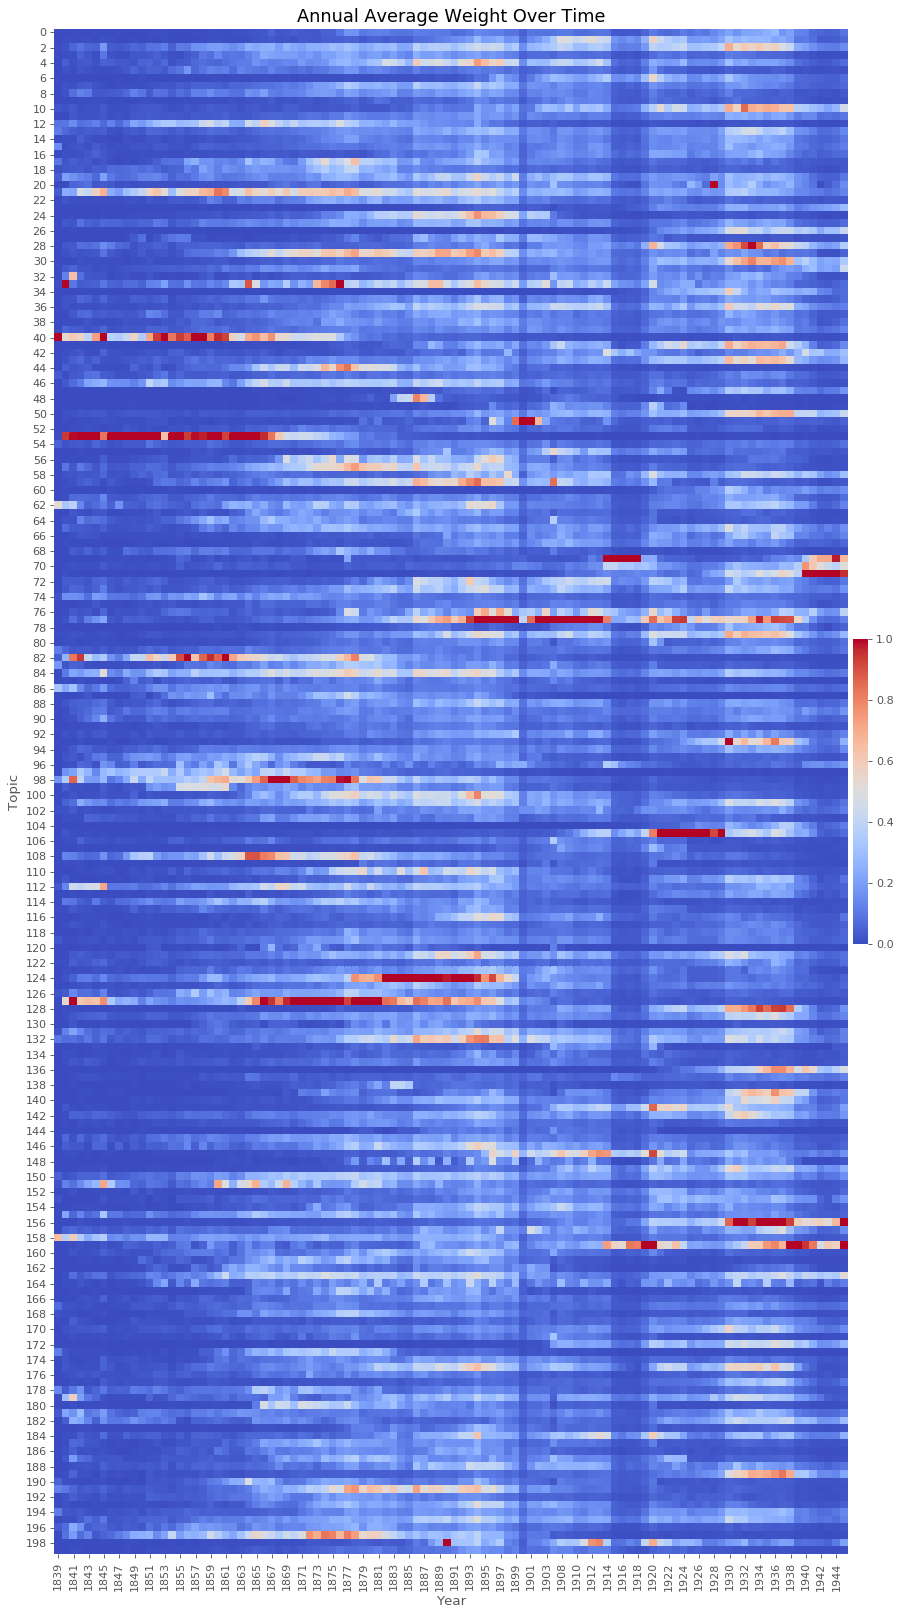

In [9]:
plot_heatmap(df_plt_scaled, path='../temp/plot_heatmap.png')

In [ ]:
# this is for presentation slides.
#plot_heatmap(df_plt_scaled, T=True, path='../temp/plot_heatmap_T.png')

## 3 Specific Topics

### 3.1 The Hotest Annual Topics

**From the [Annual Average Weight Over Time plot](#hot) we see the red spots, each red spot means this topic (y axis) is the hotest topic of this year (x axis), some topics are the hotest topic in continuely years. We filter out the hot topics and sort them by the count of being hot topic, which are the hotest topics.**

In [11]:
df_hot = pd.DataFrame(df_plt_scaled.astype(int).sum(axis=1), columns=['count'])
df_hot = df_hot[(df_hot != 0).any(axis=1)].sort_values(by='count', ascending=False)
topic_list = df_hot.index.tolist()
print('The hotest topics:')
df_hot.T

Most hot topics:


53   124  77   127  156  71   105  40   69   98   82   159  33   20   \
count   13   10    9    8    7    5    5    3    3    3    2    2    2    1   

       93   51   198  
count    1    1    1

In [12]:
df_topics_hot = filter_topics(df_topics, topic_list).set_index('topic')
df_topics_hot.loc[topic_list].head(len(topic_list))

weight  \
topic            
53     0.00348   
124    0.00914   
77     0.04036   
127    0.00831   
156    0.00977   
71     0.00452   
105    0.00663   
40     0.00566   
69     0.00744   
98     0.01129   
82     0.00688   
159    0.01358   
33     0.03857   
20     0.00452   
93     0.00339   
51     0.00626   
198    0.00768   

                                                                                                                      keywords  
topic                                                                                                                           
53     cases ditto sale casks boxes oil case white brandy foot ale tea sugar cwt assorted bags undersigned candles cubic iron   
124    london government british french foreign sir england news lord paris received france english general india march gre...  
77     association press received telegraph copyright london united july electric cable june sydney august april march aust...  
127    arrived tons port wellington sailed auckland schooner cargo yesterday melbourne left barque passengers lyttelton syd...  
156    government scheme department board work made system service local present public control minister new_zealand time d...  
71     air flying flight london aeroplane british aircraft machine miles bombs aeroplanes force enemy raid japanese machine...  
105    theatre picture pictures story programme to-night drama film comedy love star shown great girl play life feature nig...  
40     government provincial province council colony general superintendent public governor new_zealand colonial assembly h...  
69     german enemy germans front french british london fighting troops attack captured received line artillery russian sta...  
98     business public notice begs attention orders inform premises patronage general support stock undersigned advertiseme...  
82     sale apply land acres house particulars property terms town good sections situated lease section years farm road fre...  
159    german germany war france peace french berlin russia government allies received london paris italy germans britain b...  
33                                      tin ill oil lit mil day zealand ton tie hat aro fur aid tins ail end man hut til time   
20     auckland wellington left due london lyttelton october sydney december march january september february sailed novemb...  
93          good race mile furlongs ran won day straight run home half horse handicap field horses back front winner time win   
51     south africa boers british war general transvaal contingent boer london lord received african cape capetown men troo...  
198    strike union men miners labour work workers coal federation association conference labor dispute unions wages strike...

**Plot all average weight to check trend of each hotest topic.**

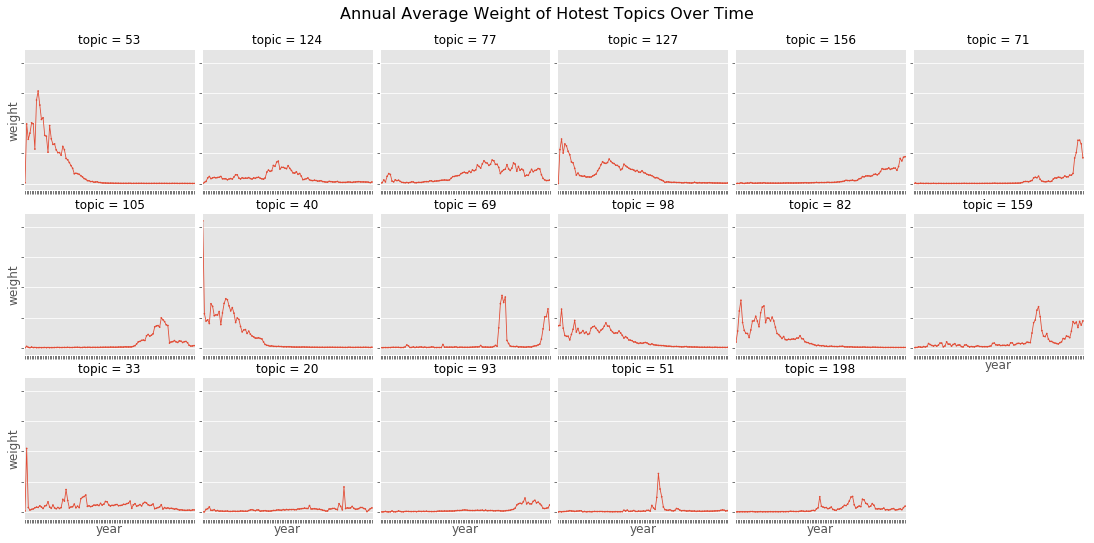

In [13]:
df_plt_avg = filter_topics(df_avgweight, topic_list)

plot_avg(df_plt_avg, col_wrap=6, col_order=topic_list, height=2.5, scale=0.3, adjust_top=0.9, 
         title='Annual Average Weight of Hotest Topics Over Time',
         path='../temp/plot_hotavg.png')

**Plot all hot topics with:**
* annual average weight
* dominant topic distribution
* dominant topic count

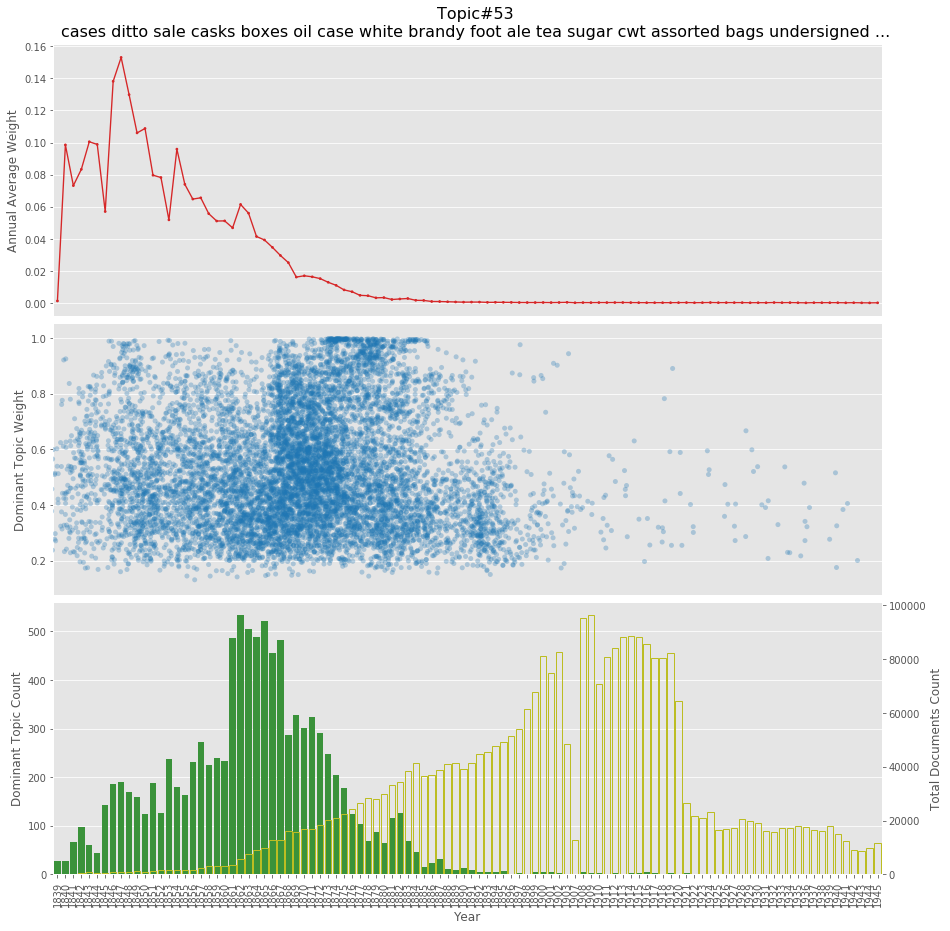

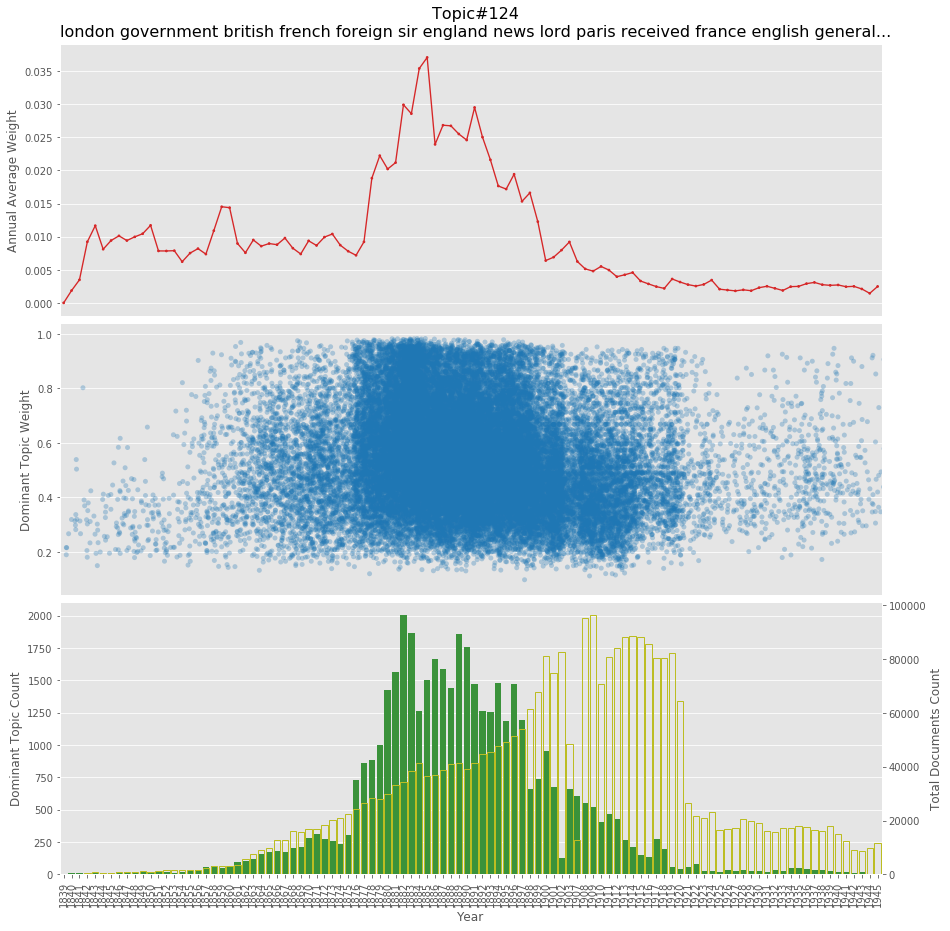

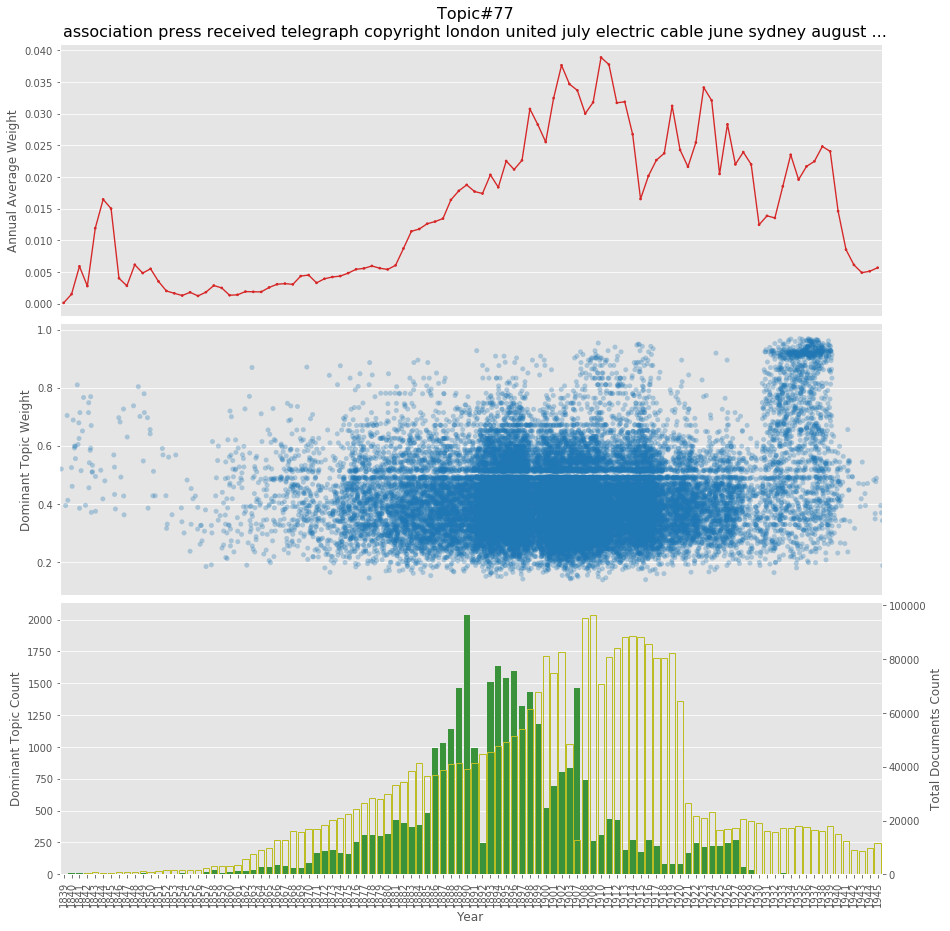

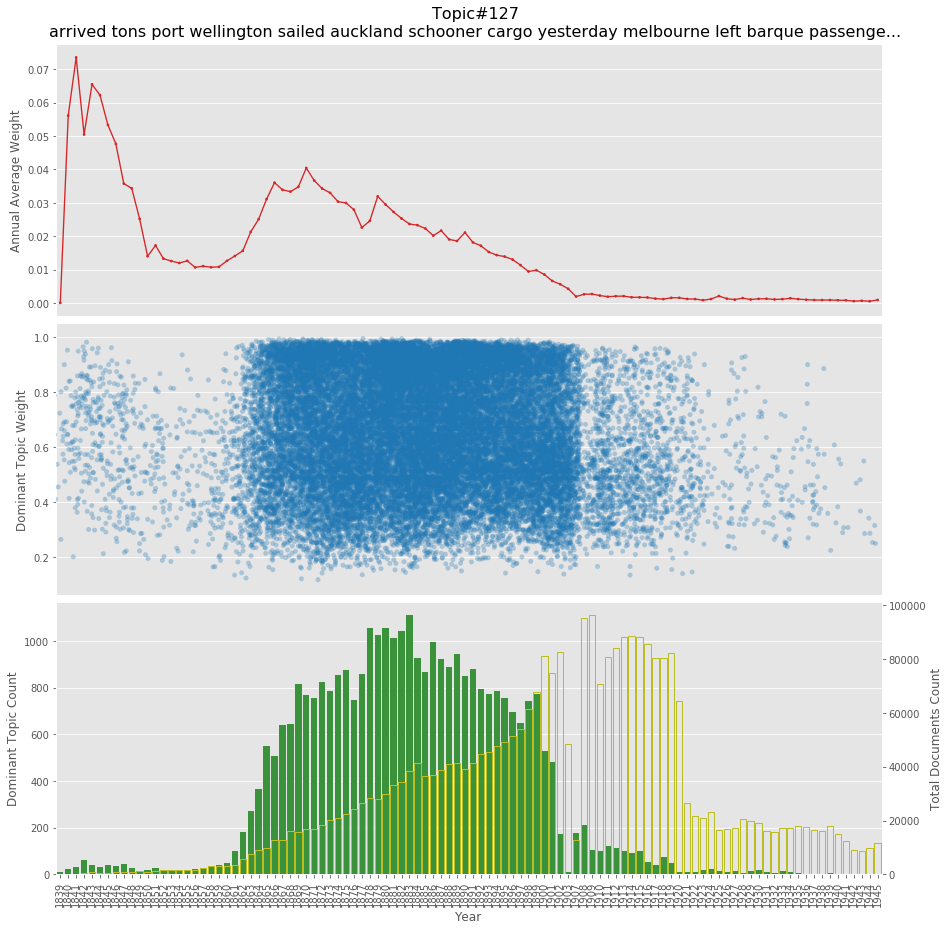

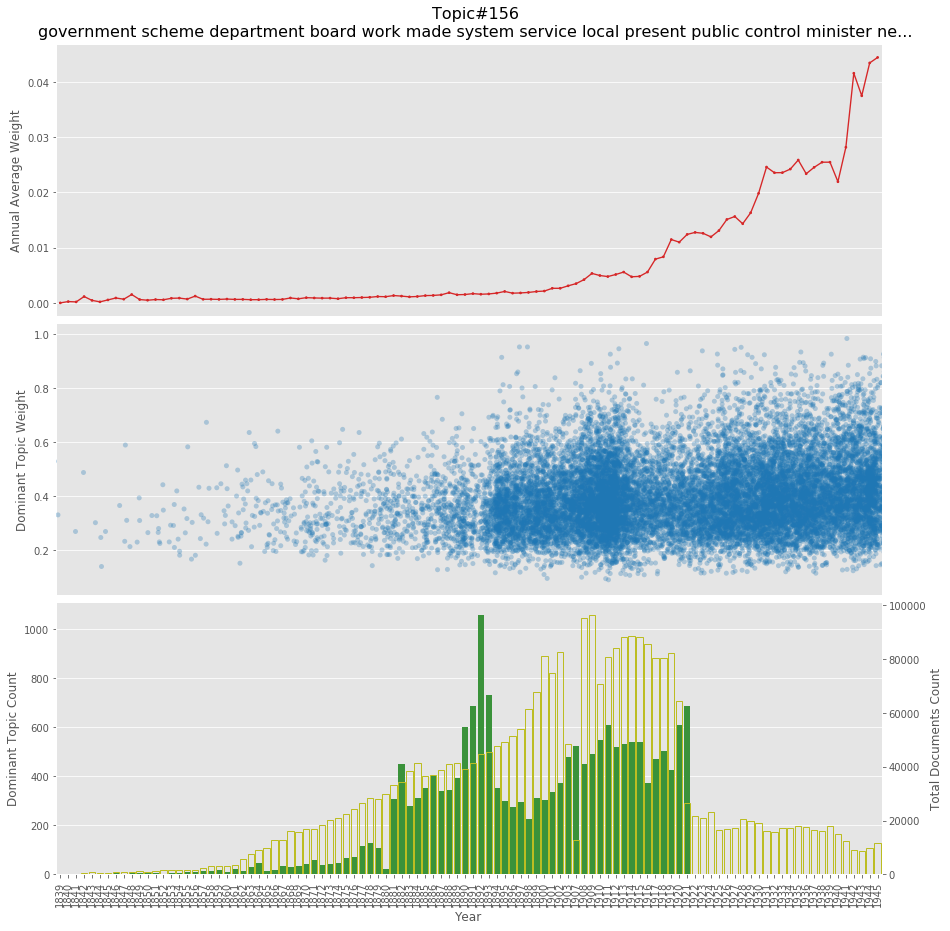

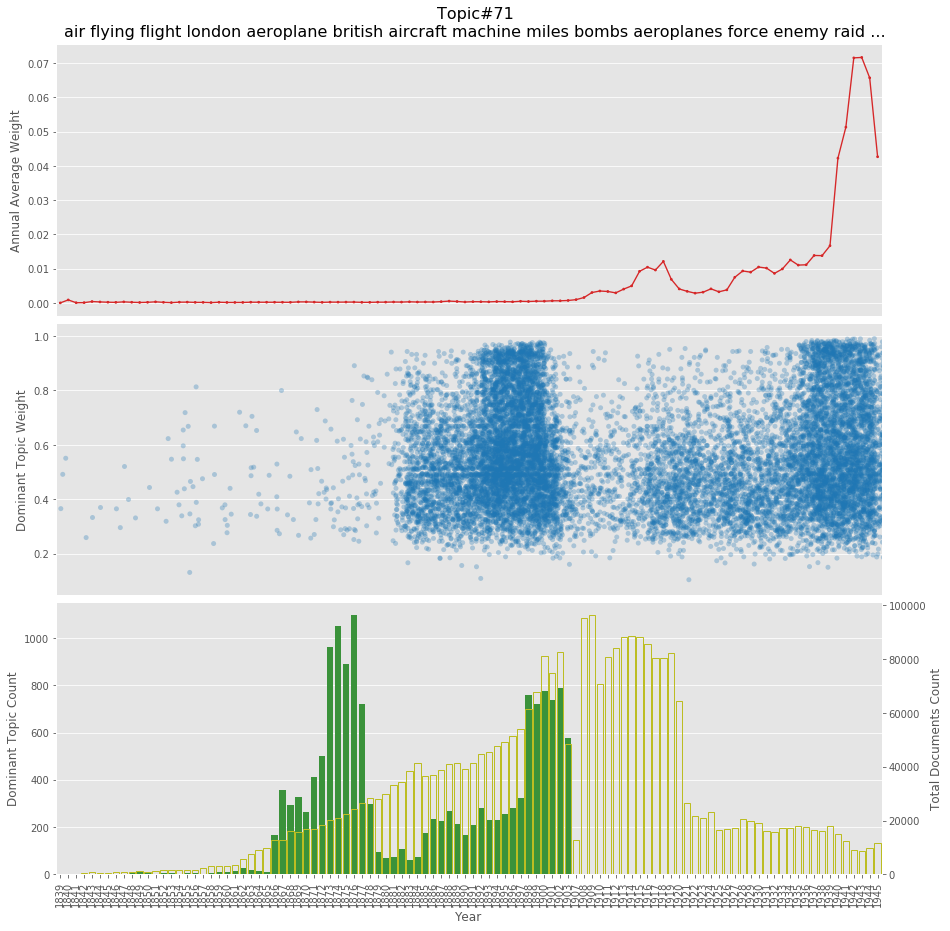

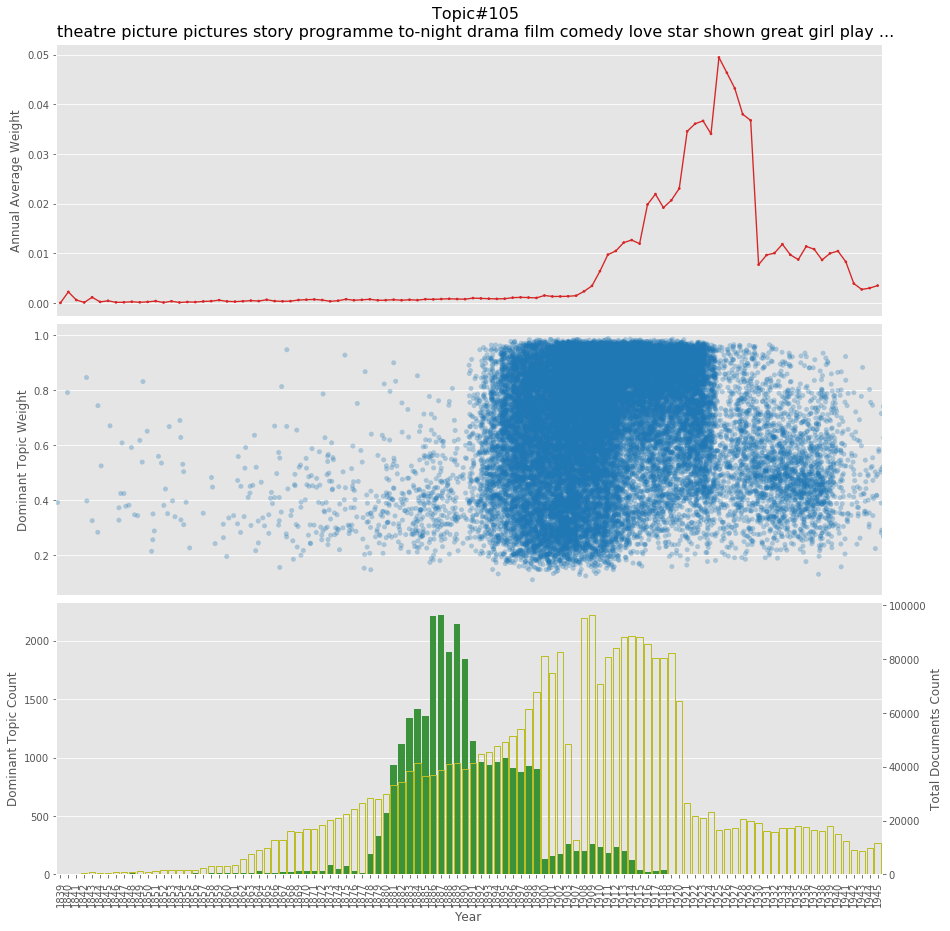

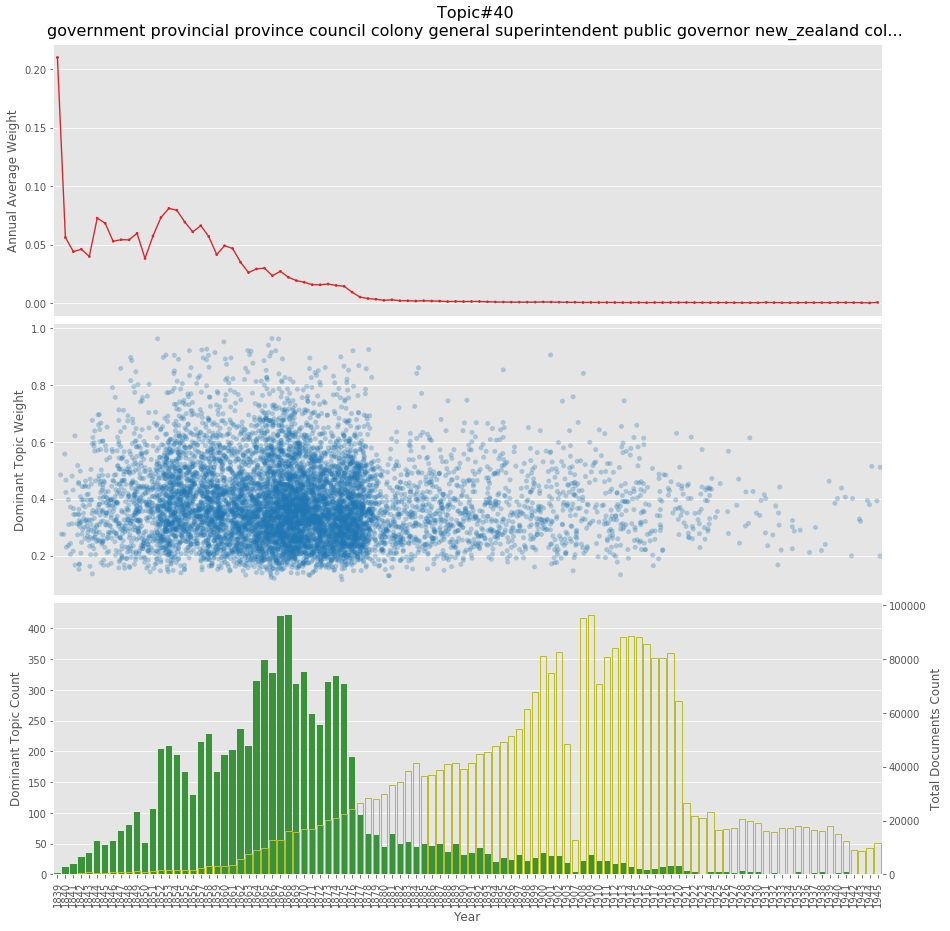

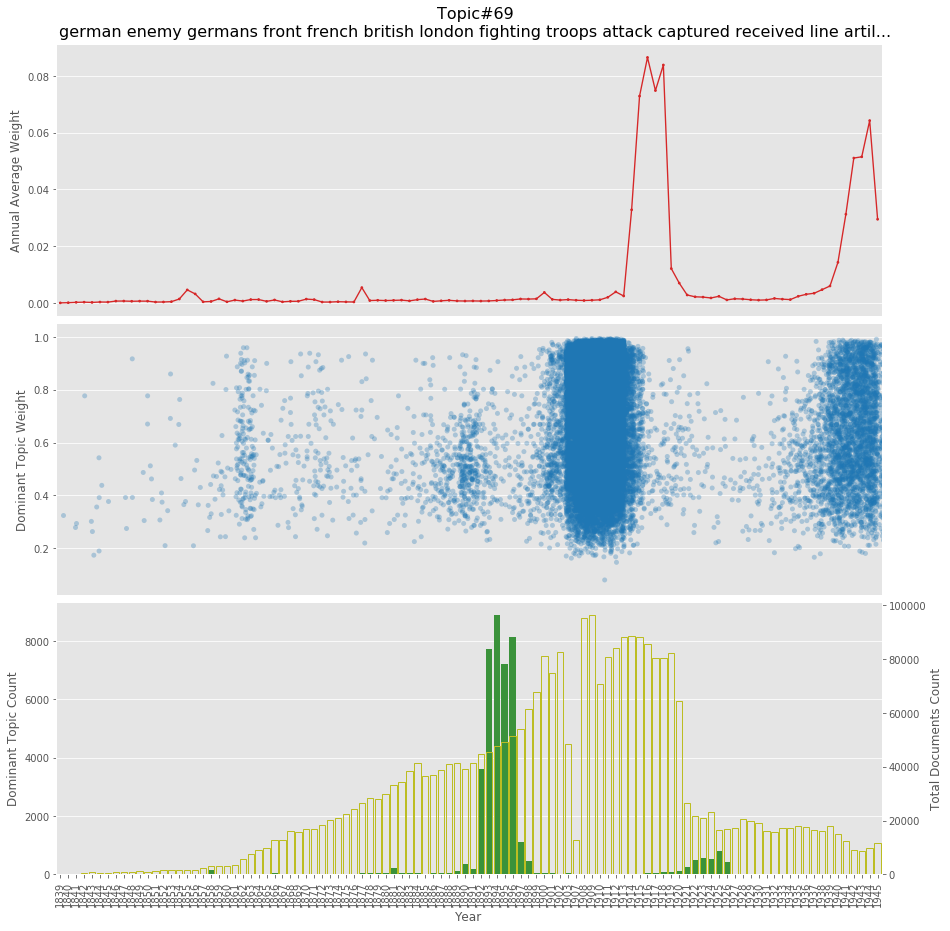

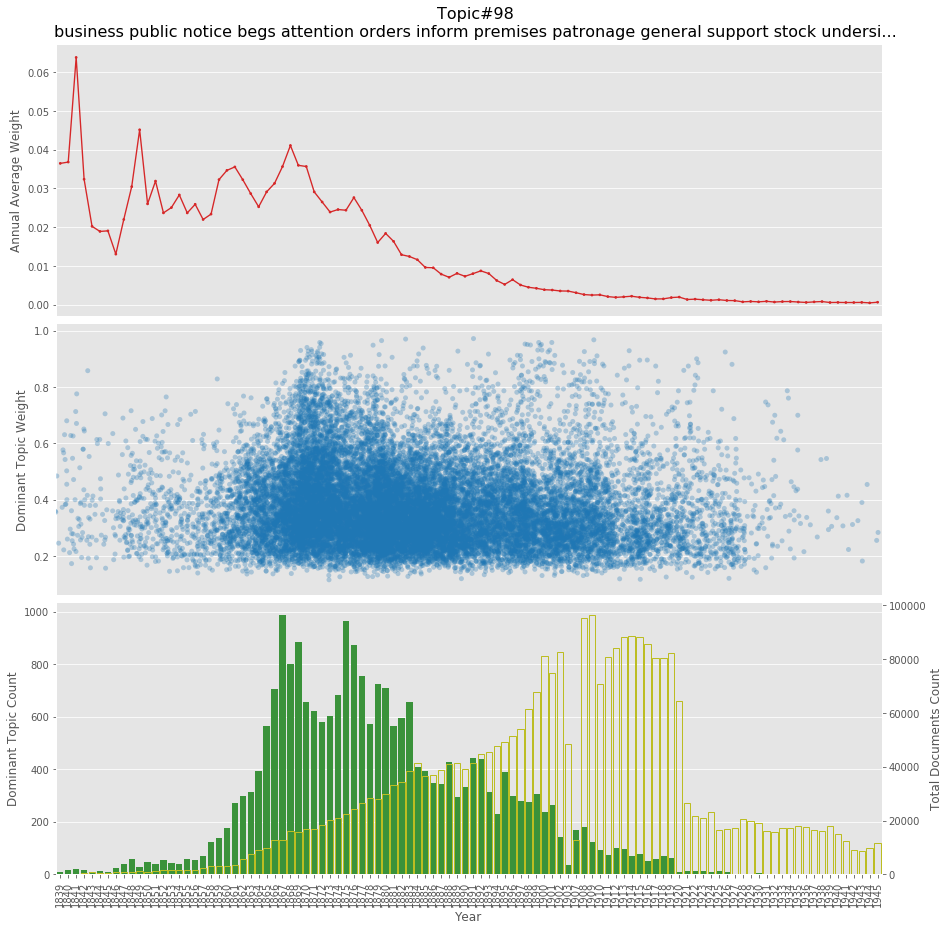

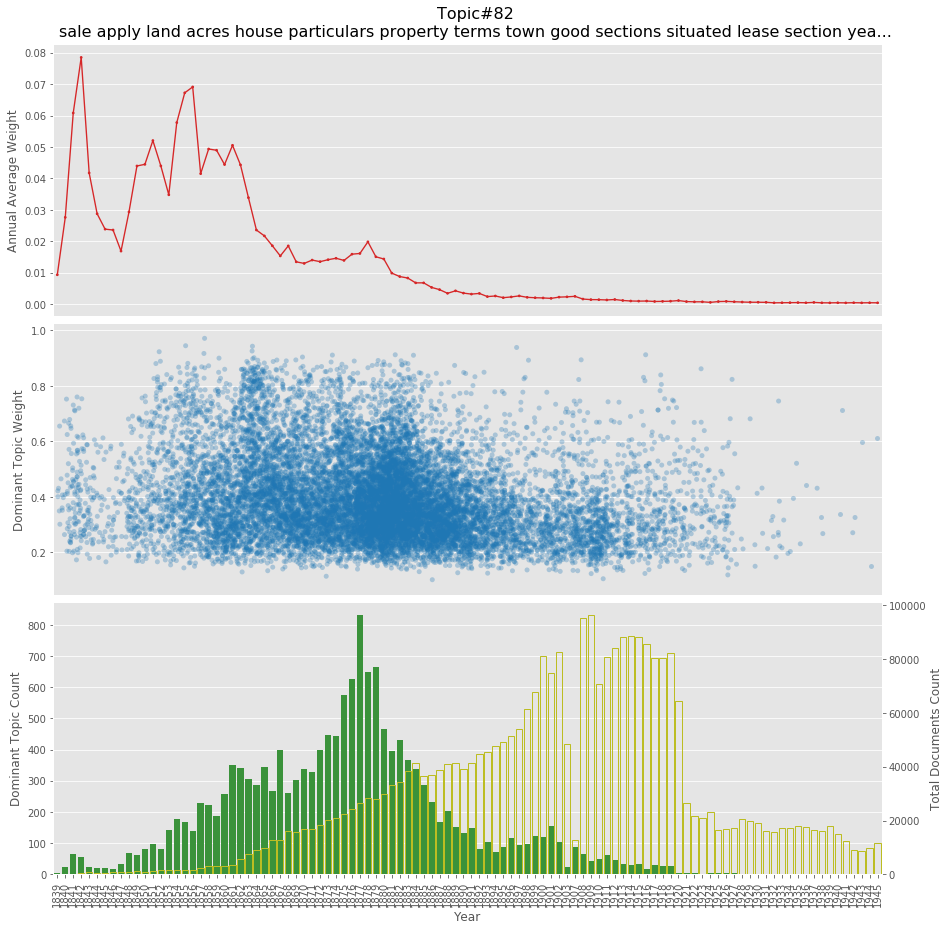

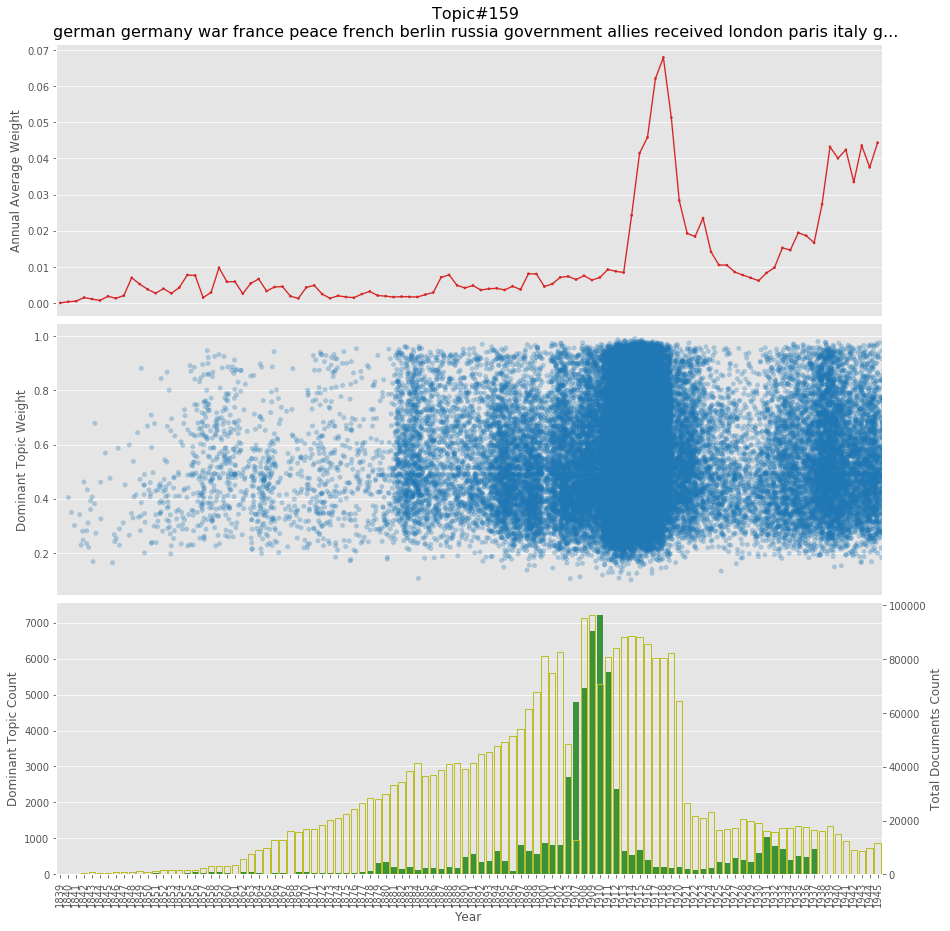

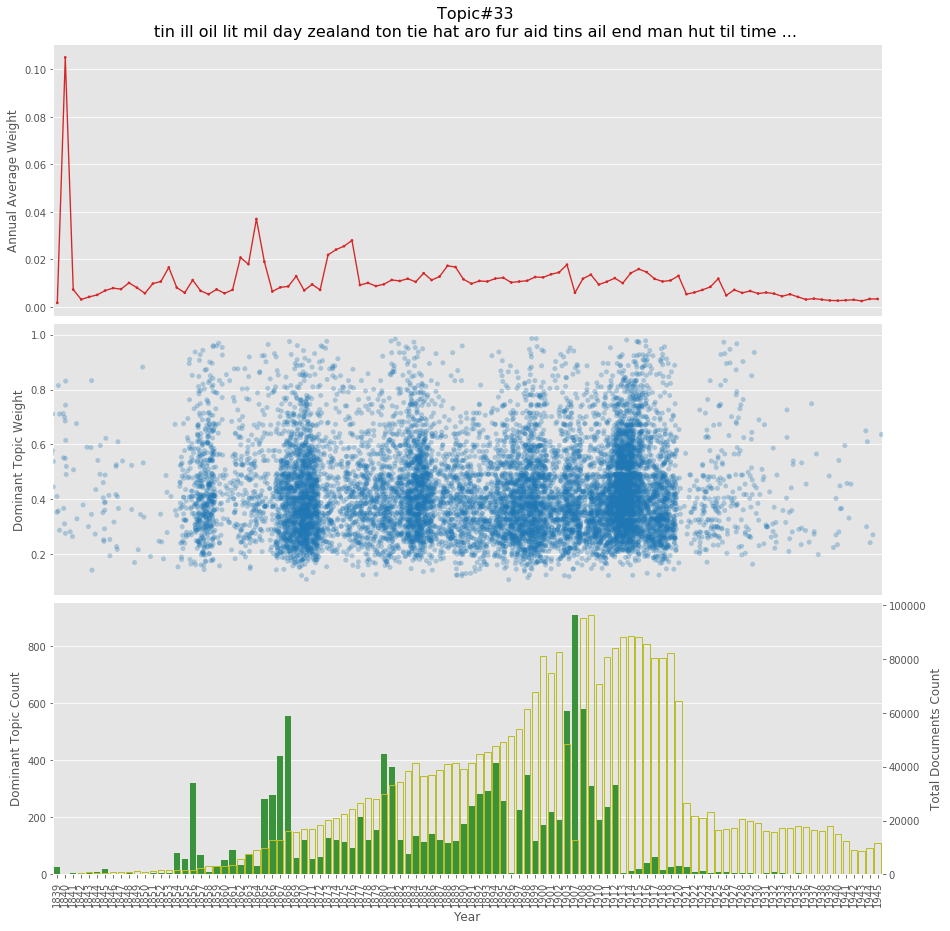

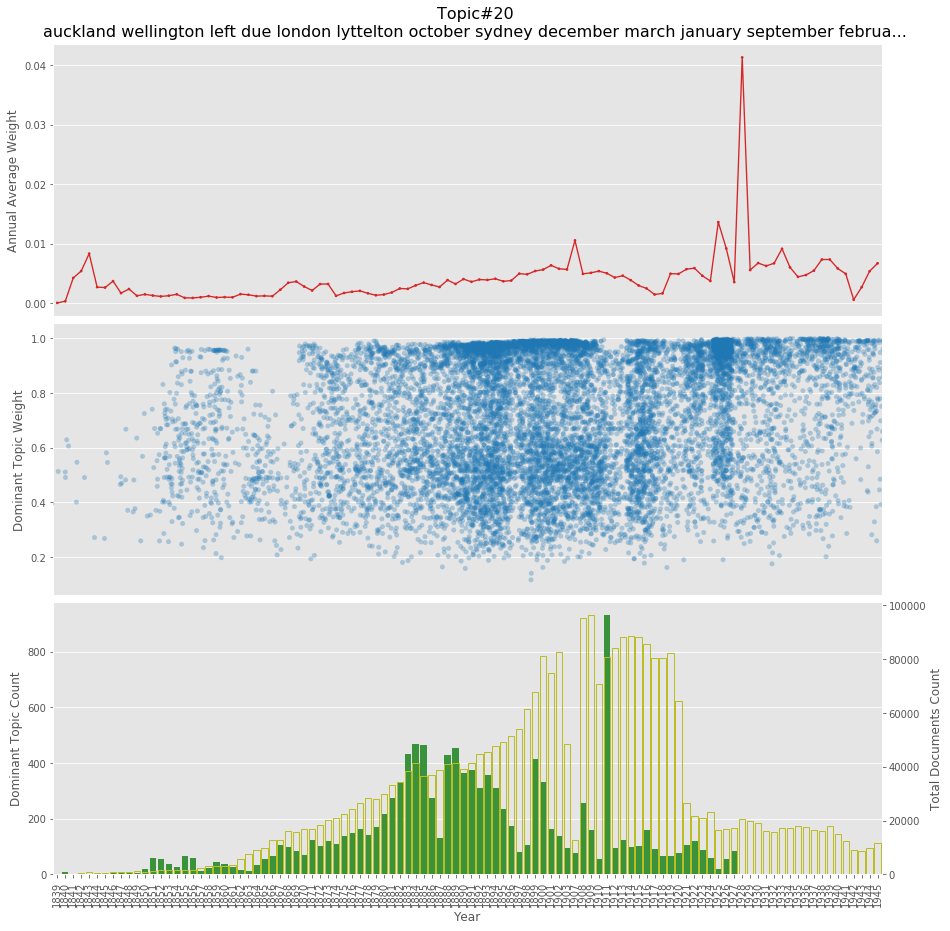

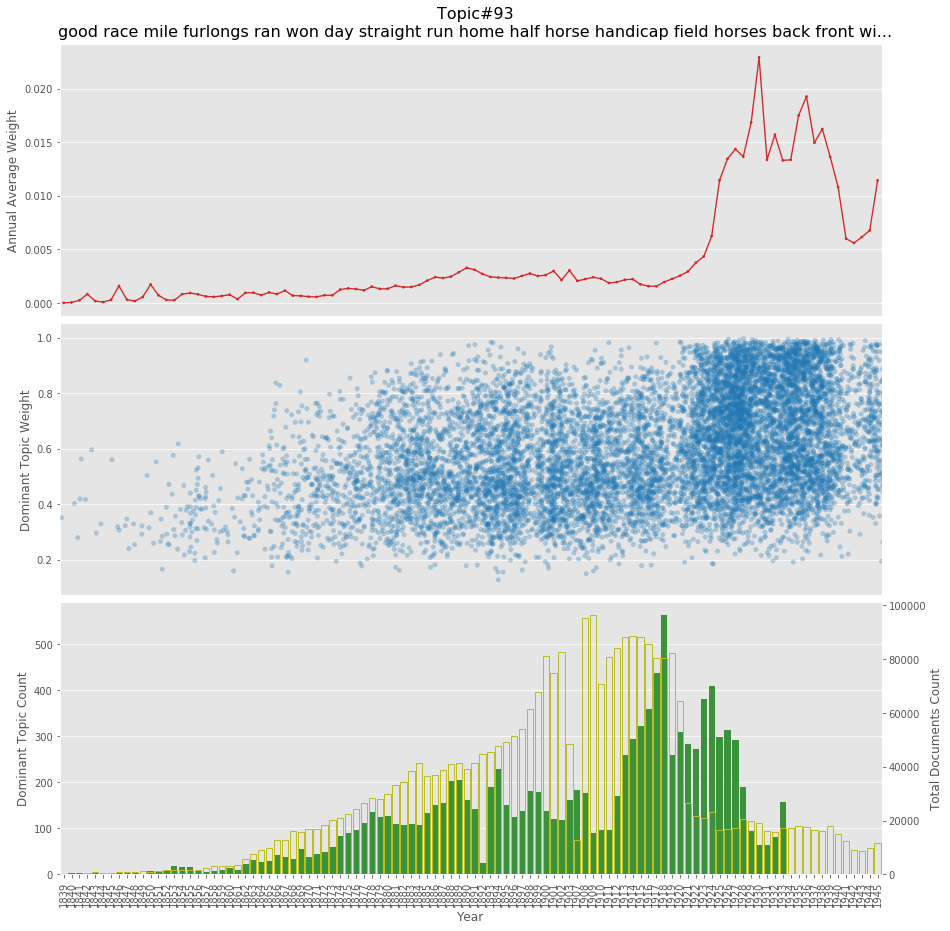

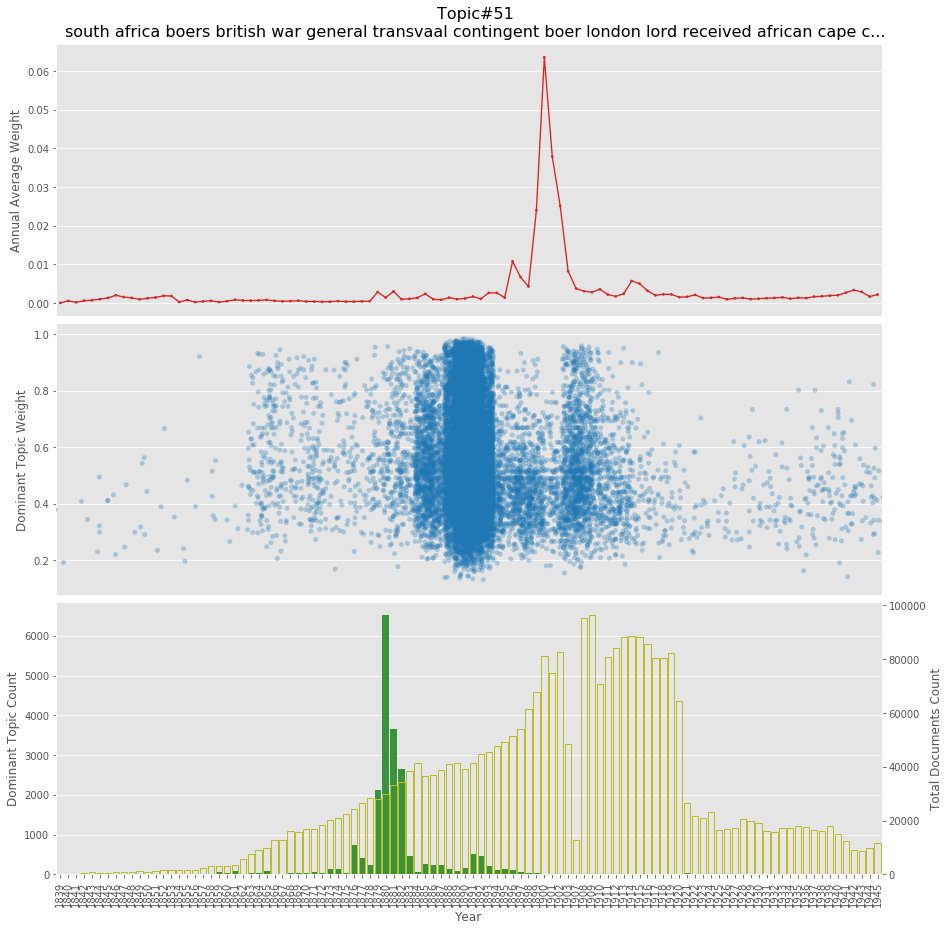

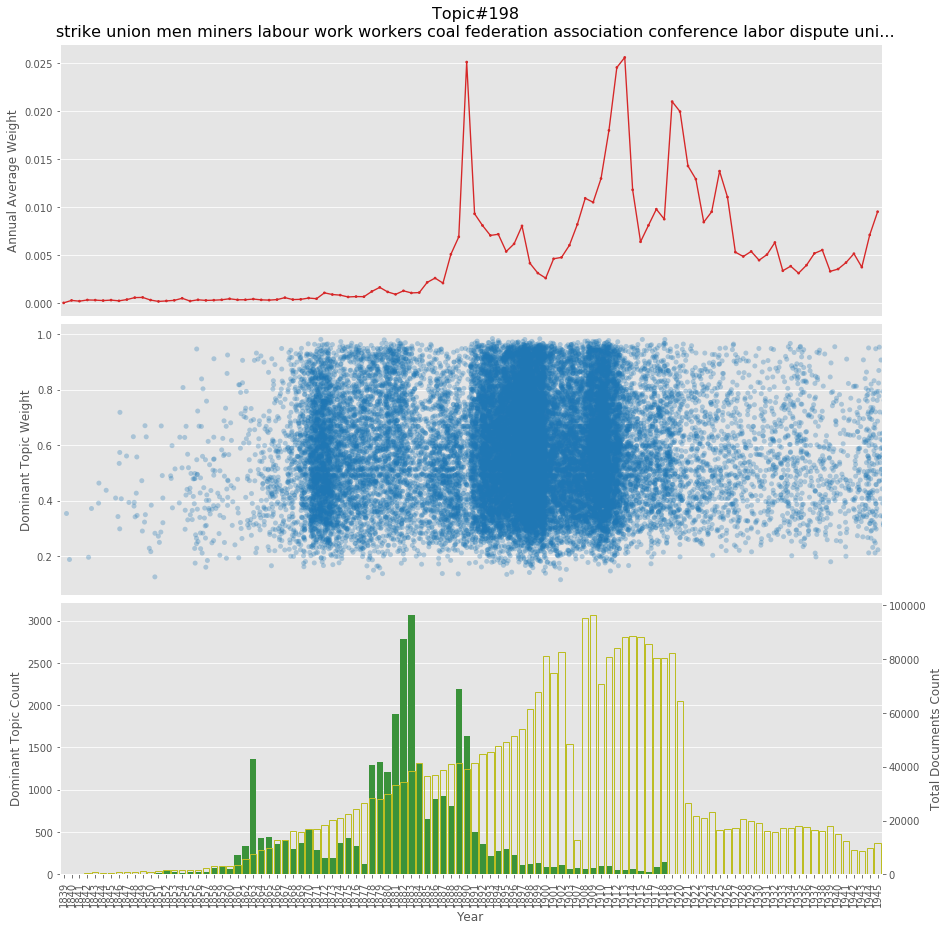

In [14]:
for topic in topic_list:
    plot_hot(topic, df_topics, df_domtopic, df_avgweight, path='../temp/plot_hot.png')

### 3.2 The Hotest Event Topics

**In specific historical events period, we calculate the average weight of each topic in this specific historical event period and compare with its overall average weight, and sort the differences between event period average weight and overall average weight to get the most weight increased topic, which is the hotest event topics.**

**Historical events:**

1. **The New Zealand Wars (1845 - 1872)** Another consequence of the treaty signing was war. Disputes of land and sovereignty occurred between the European immigrants and the Maori. The wars were quite intermittent and were spaced out between the 1840s and 1860s -1870s. An interesting aspect of the New Zealand Wars is that they mostly took place in the north island, specifically Waikato and Taranaki. So we could expect mentions wars of these wars in more in the north island publications over the south island. For example, we could expect place names of battle sites and “muskets”. 

1. **Gold Rush - Otago and West Coast (1860s)** The gold rush caused a huge increase in interest for New Zealand attractive people from all over the world to chase the gold, including people from Europe and China. It was mostly in Otago but some gold mines were in the West Coast of the south island. This again led to a surge in population. Dunedin increased from 35,000 to 100,000 over one year in 1863. This is another example of a region-specific event. Although it attracted people worldwide, we could probably expect a higher count of Otago and west coast publication discussing the gold rush versus a northland publication.
 
1. **Women's Suffrage Movement (1893)** The suffrage movement was led by the activist Kate Shepard. It was a movement to give females the right to vote in parliamentary elections. The significance of this event was that New Zealand was the first country in the world to give pass the law securing female’s right to vote. This obviously led to global news and we can expect this topic to be highly discussed in this time period. 

1. **The Boer War (1899 -1902)** The Boer war was fought between the British Empire and the Boer South African Republic. New Prime Minister, Richard Seddon, was quick to support the British Empire. Over the 2.5 years of war, New Zealand set 6,500 troops. Many troops ( 133) died due to poor conditions such as poor rations and disease, a large proportion of the 230 troops who died. It was a significant event, the New Zealand soldiers were considered strong soldiers, despite inadequate training and equipment. It sparked a wave of patriotism and showed New Zealand’s commitment to the British. This led to New Zealand’s involvement in the two world wars in the following decades. 

1. **World War 1 (1914 - 1918)** This is one of the most important events of the nineteenth century. Not just in New Zealand but the whole world. Following the trend of the Boer war. New Zealand committed troops to support the British ( and allies). The Gallipoli campaign when down as a tragic defeat for the ANZAC troops. New Zealand suffered 2,779 casualties in Gallipoli. One in four of the troops aged 20 to 45 that were deployed, were either killed or injured. There were devastating losses and we could expect World War 1 to be a higher discussed topic in the publications. 

1. **The Great Depression (1930s)** The great depression was the greatest crash of financial systems in world history. The depression led to run on banks, mass unemployment. There were government relief schemes put in place after there were riots in the major cities. This led to labour restructures and the creation of unions. Another important aspect of this period is that New Zealand was heavily depended on for its agriculture exports for Britain. So we could expect the mention of; ‘exports’, ‘wages’, ‘unemployment’, ‘unions’ during this time period.  

1. **World War 2 (1939 - 1945)**  The biggest war in world history. New Zealand again followed Britain and Australia to war. New Zealand had a contributed to the war effort in both European and the Pacific theatres. New Zealand sent about 140,000 people in numerous services to help in the war. It is also estimated that New Zealand suffered the most casualties (6,684) per capita of the commonwealth countries. Versus 5123 and 3232 for Britain and Australia, respectively. As World War 1, we could probably expect this to be a higher discussed topic nationwide.

#### 3.2.1 The New Zealand Wars (1845 - 1872)

**we set the time range list to 1845 - 1872, and calculate the average weight of each topics during this period.**

In [5]:
# set event period
start = 1845
end   = 1872
event_range = list(range(start, end + 1))

# load annual average wegith dataframe
path = r'../models/train/avgWeight.csv'

# generate new column names
columns = [str(x) for x in list(range(topics_shape[0]))]
columns.insert(0, 'year')

df = pd.read_csv(path, 
                       header=None, 
                       index_col=None, 
                       names = columns,
                       encoding='utf8')

df_event = df[df['year'].isin(event_range)]

df_topics_event = df_topics.copy(deep=True)

# get topic overall average weight and event average weight
df_topics_event['event'] = df_event[df_event.columns[1:]].mean().values

# sort the most vary topic
df_topics_event['diff'] = (df_topics_event['event'] - df_topics_event['weight']) / df_topics_event['weight']

df_topics_event = df_topics_event.sort_values(by='diff', ascending=False)

# the hotest topic of an event
topic_event = df_topics_event.iloc[0][0]
print('The hotest topic during event is topic #', topic_event)

df_topics_event.head(5)

The hotest topic during event is topic # 53


topic   weight  \
53     53  0.00348   
97     97  0.00210   
40     40  0.00566   
82     82  0.00688   
12     12  0.00465   

                                                                                                                   keywords  \
53  cases ditto sale casks boxes oil case white brandy foot ale tea sugar cwt assorted bags undersigned candles cubic iron    
97  cases case tons bags casks bales boxes sacks packages pkgs kegs cask box schooner bale flour sugar agent order passe...   
40  government provincial province council colony general superintendent public governor new_zealand colonial assembly h...   
82  sale apply land acres house particulars property terms town good sections situated lease section years farm road fre...   
12  freight apply passage new_zealand company steam passengers london steamers shipping tons wellington agents line stea...   

       event       diff  
53  0.062866  17.065061  
97  0.021790   9.376223  
40  0.045522   7.042792  
82  0.034714   4.045586  
12  0.018417   2.960682

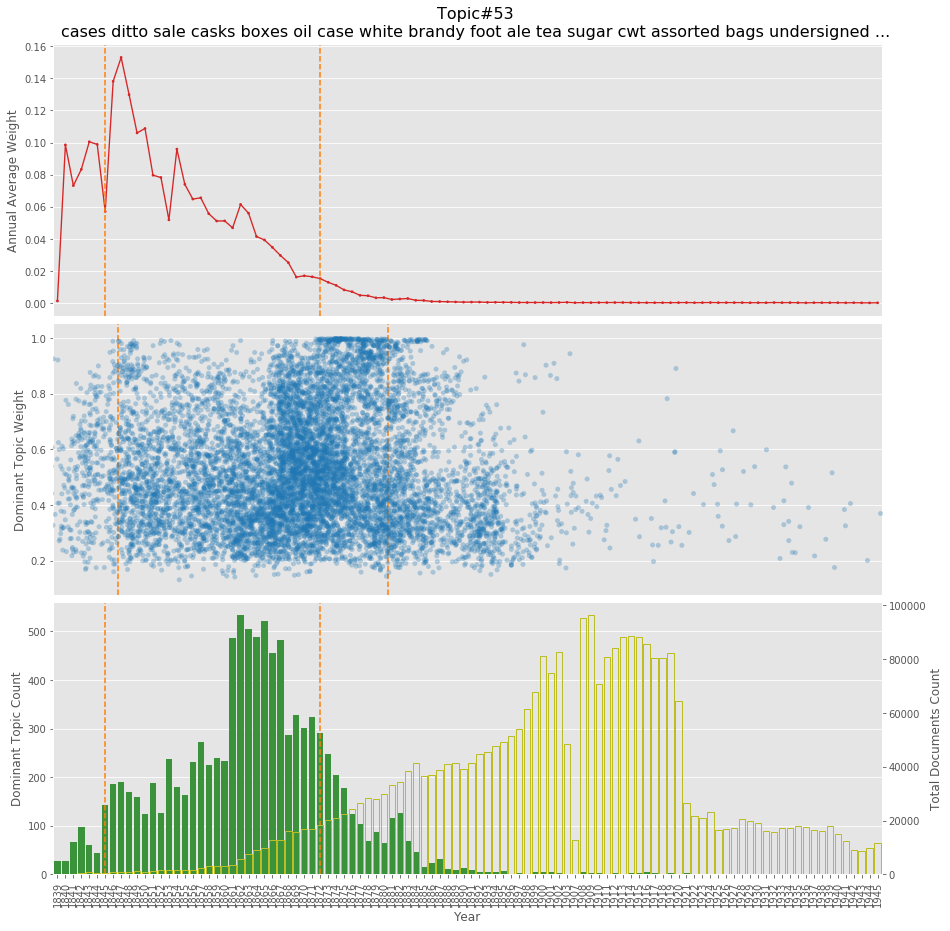

In [6]:
plot_hot(topic_event, df_topics, df_domtopic, df_avgweight, x1=start, x2=end)

#### 3.2.2 Gold Rush - Otago and West Coast (1860s)

In [7]:
start = 1860
end   = 1869

df_topics_event = gen_event(start, end, df_topics)

# the hotest topic of an event
topic_event = df_topics_event.iloc[0][0]
print('The hotest topic during event is topic #', topic_event)

df_topics_event.head(5)

The hotest topic during event is topic # 53


topic   weight  \
53      53  0.00348   
97      97  0.00210   
40      40  0.00566   
82      82  0.00688   
108    108  0.00765   

                                                                                                                    keywords  \
53   cases ditto sale casks boxes oil case white brandy foot ale tea sugar cwt assorted bags undersigned candles cubic iron    
97   cases case tons bags casks bales boxes sacks packages pkgs kegs cask box schooner bale flour sugar agent order passe...   
40   government provincial province council colony general superintendent public governor new_zealand colonial assembly h...   
82   sale apply land acres house particulars property terms town good sections situated lease section years farm road fre...   
108  auction sale o'clock sell public instructions day saturday rooms auctioneers auctioneer wednesday received messrs lo...   

        event       diff  
53   0.040208  10.553907  
97   0.014913   6.101470  
40   0.030971   4.471825  
82   0.028445   3.134484  
108  0.027627   2.611409

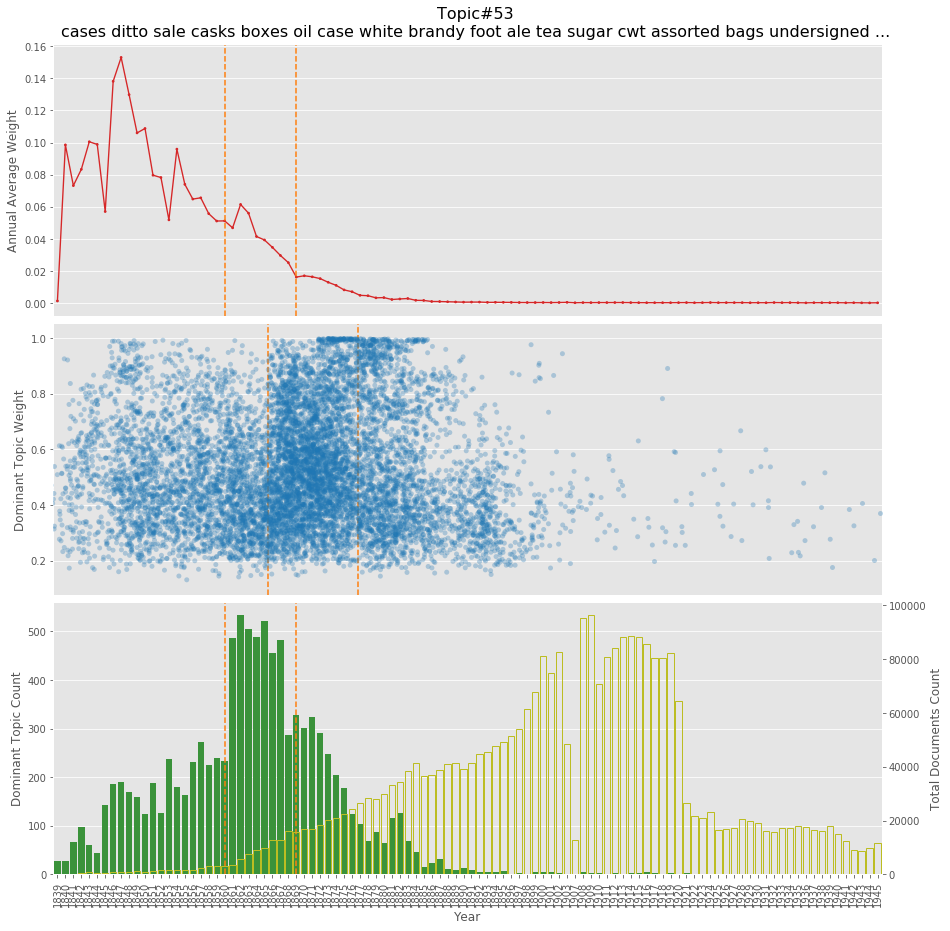

In [8]:
plot_hot(topic_event, df_topics, df_domtopic, df_avgweight, x1=start, x2=end)

#### 3.2.3 Women's Suffrage Movement (1893)

In [9]:
start = 1893
end   = 1893

df_topics_event = gen_event(start, end, df_topics)

# the hotest topic of an event
topic_event = df_topics_event.iloc[0][0]
print('The hotest topic during event is topic #', topic_event)

df_topics_event.head(5)

The hotest topic during event is topic # 24


topic   weight  \
24      24  0.00344   
148    148  0.00280   
29      29  0.00658   
124    124  0.00914   
59      59  0.00813   

                                                                                                                    keywords  \
24           handicap time won meeting dividend sec mile yrs bst races miles stakes race lady soys started min cup club day    
148  cricket innings wickets match team runs australians england wicket australia australian made south bowling play elev...   
29   mails mail close office letters auckland notices united_kingdom chief wellington post late europe london due fee con...   
124  london government british french foreign sir england news lord paris received france english general india march gre...   
59   wellington nelson morning to-morrow arrived saturday tons westport moon picton leaves coast wednesday to-day monday ...   

        event      diff  
24   0.014015  3.074074  
148  0.007545  1.694710  
29   0.015916  1.418897  
124  0.021607  1.364017  
59   0.017050  1.097110

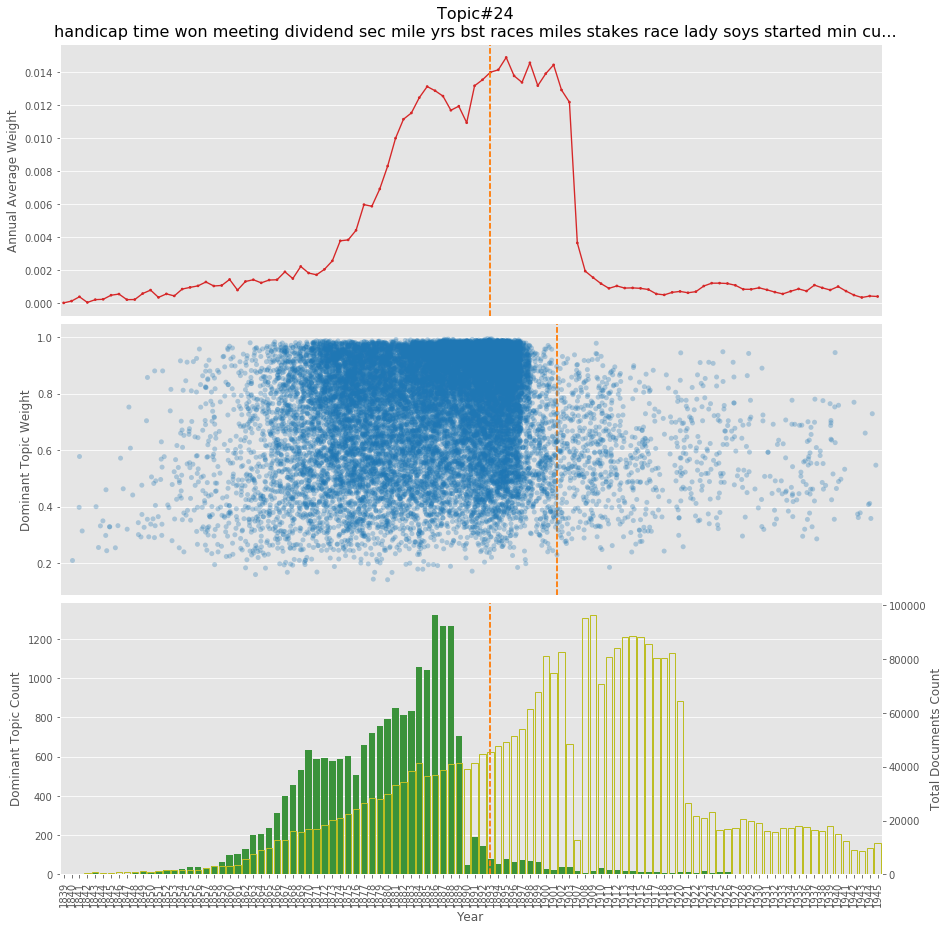

In [10]:
plot_hot(topic_event, df_topics, df_domtopic, df_avgweight, x1=start, x2=end)

#### 3.2.4 The Boer War (1899 -1902)

In [11]:
start = 1899
end   = 1902

df_topics_event = gen_event(start, end, df_topics)

# the hotest topic of an event
topic_event = df_topics_event.iloc[0][0]
print('The hotest topic during event is topic #', topic_event)

df_topics_event.head(5)

The hotest topic during event is topic # 51


topic   weight  \
51      51  0.00626   
24      24  0.00344   
27      27  0.00355   
144    144  0.00118   
148    148  0.00280   

                                                                                                                    keywords  \
51   south africa boers british war general transvaal contingent boer london lord received african cape capetown men troo...   
24           handicap time won meeting dividend sec mile yrs bst races miles stakes race lady soys started min cup club day    
27   pills kidney years backache cure cured time medicine good health pain great back doan's kidneys pains remedy sufferi...   
144  extract sander eucalypti sons eucalyptus sander's medical advertisements column genuine effects inflammation wounds ...   
148  cricket innings wickets match team runs australians england wicket australia australian made south bowling play elev...   

        event      diff  
51   0.037617  5.009089  
24   0.013632  2.962929  
27   0.008985  1.530991  
144  0.002854  1.418530  
148  0.005825  1.080286

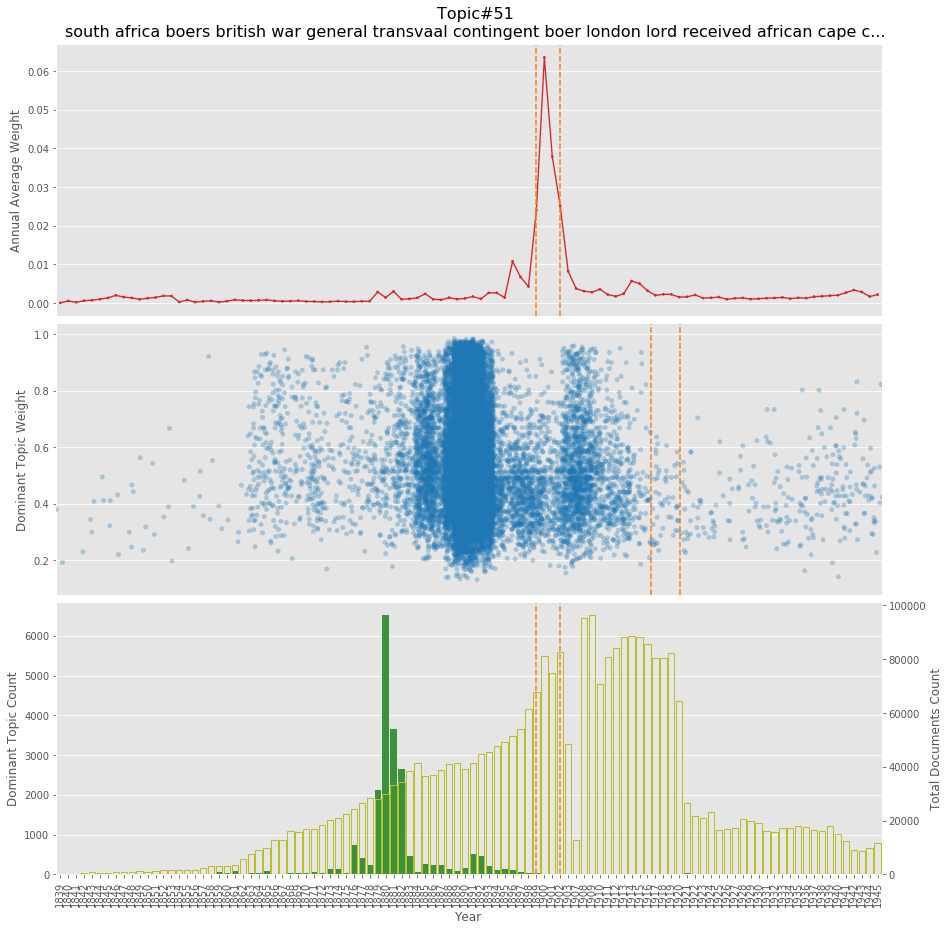

In [12]:
plot_hot(topic_event, df_topics, df_domtopic, df_avgweight, x1=start, x2=end)

#### 3.2.5 World War 1 (1914 - 1918)

In [13]:
start = 1914
end   = 1918

df_topics_event = gen_event(start, end, df_topics)

# the hotest topic of an event
topic_event = df_topics_event.iloc[0][0]
print('The hotest topic during event is topic #', topic_event)

df_topics_event.head(5)

The hotest topic during event is topic # 69


topic   weight  \
69      69  0.00744   
159    159  0.01358   
42      42  0.00719   
172    172  0.00242   
105    105  0.00663   

                                                                                                                    keywords  \
69   german enemy germans front french british london fighting troops attack captured received line artillery russian sta...   
159  german germany war france peace french berlin russia government allies received london paris italy germans britain b...   
42   naval ships british navy fleet german sea vessels submarine admiral war admiralty ship london tons guns sunk submari...   
172     handicap time won furlongs sec started lady length soys lengths mile meeting miles hack half day min ssec gold king    
105  theatre picture pictures story programme to-night drama film comedy love star shown great girl play life feature nig...   

        event      diff  
69   0.070160  8.430061  
159  0.048297  2.556473  
42   0.020900  1.906823  
172  0.006966  1.878371  
105  0.017109  1.580613

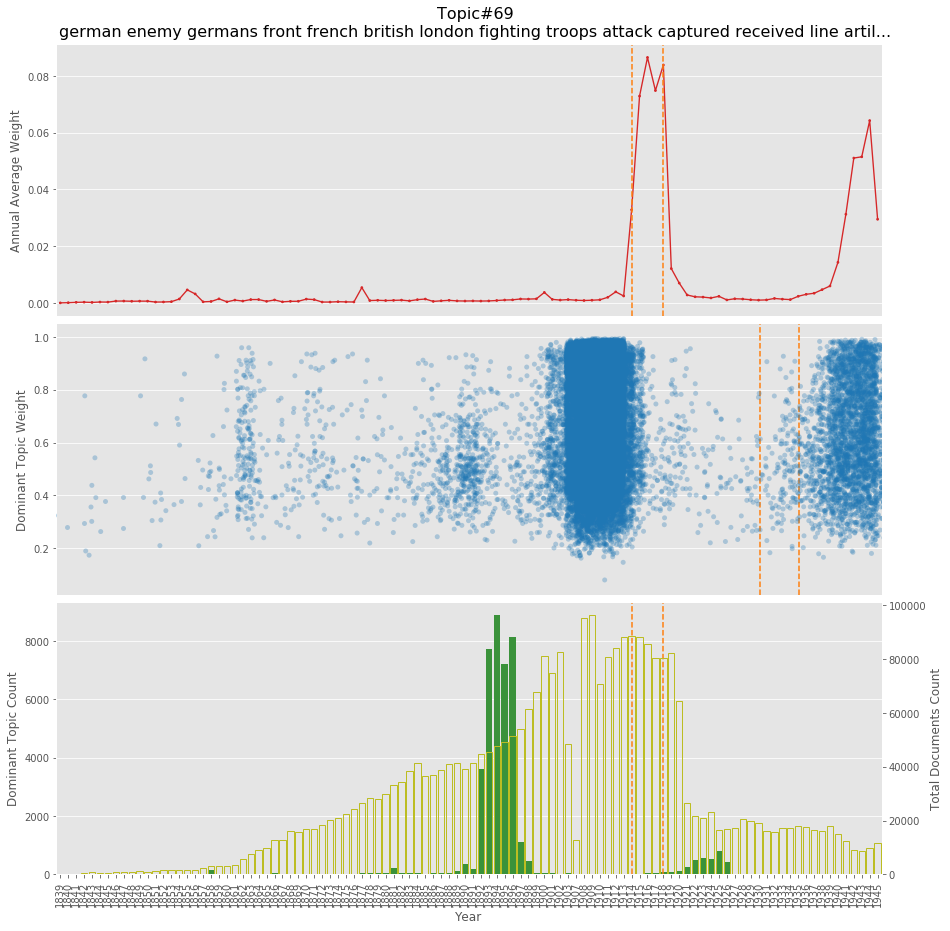

In [14]:
plot_hot(topic_event, df_topics, df_domtopic, df_avgweight, x1=start, x2=end)

#### 3.2.6 The Great Depression (1930s) 

In [15]:
start = 1930
end   = 1939

df_topics_event = gen_event(start, end, df_topics)

# the hotest topic of an event
topic_event = df_topics_event.iloc[0][0]
print('The hotest topic during event is topic #', topic_event)

df_topics_event.head(5)

The hotest topic during event is topic # 136


topic   weight  \
136    136  0.00167   
139    139  0.00250   
34      34  0.00162   
26      26  0.00231   
104    104  0.00137   

                                                                                                                    keywords  \
136  theatre tonight universal exhibition approved adults censor recommended comedy tomorrow night dancing dance plans ge...   
139  sellers buyers stock bank sales new_zealand national exchange pref auckland waihi wellington insurance cent share or...   
34   rooms price section large bungalow terms modern deposit home good bay gas residence view tram garage house kitchenet...   
26   post wanted sell buy anted street good cash furniture write prices sale ring price apply wellington radio condition ...   
104  car cars good sedan model ford motors saloon street condition order price austin sale motor morris tyres tourer cash...   

        event      diff  
136  0.014680  7.790695  
139  0.015038  5.015386  
34   0.007953  3.909164  
26   0.011013  3.767418  
104  0.006523  3.761180

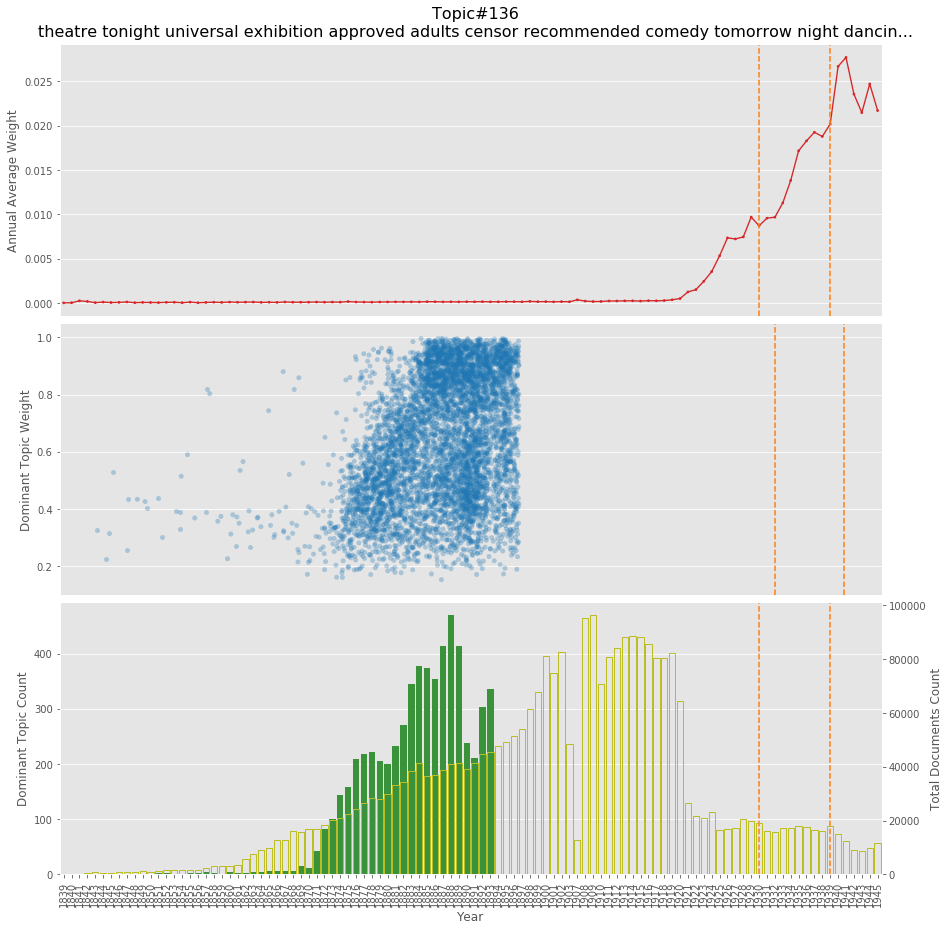

In [16]:
plot_hot(topic_event, df_topics, df_domtopic, df_avgweight, x1=start, x2=end)

#### 3.2.7 World War 2 (1939 - 1945)

In [17]:
start = 1939
end   = 1945

df_topics_event = gen_event(start, end, df_topics)

# the hotest topic of an event
topic_event = df_topics_event.iloc[0][0]
print('The hotest topic during event is topic #', topic_event)

df_topics_event.head(5)

The hotest topic during event is topic # 136


topic   weight  \
136    136  0.00167   
71      71  0.00452   
23      23  0.00140   
26      26  0.00231   
60      60  0.00134   

                                                                                                                    keywords  \
136  theatre tonight universal exhibition approved adults censor recommended comedy tomorrow night dancing dance plans ge...   
71   air flying flight london aeroplane british aircraft machine miles bombs aeroplanes force enemy raid japanese machine...   
23   loving memory dear inserted mother passed memoriam father died family brother wife sister son bereavement life sad s...   
26   post wanted sell buy anted street good cash furniture write prices sale ring price apply wellington radio condition ...   
60   post furnished rooms room apply rent flat house single board wanted unfurnished street business large convs double w...   

        event       diff  
136  0.023732  13.210757  
71   0.051679  10.433491  
23   0.011074   6.910235  
26   0.017892   6.745489  
60   0.008166   5.093939

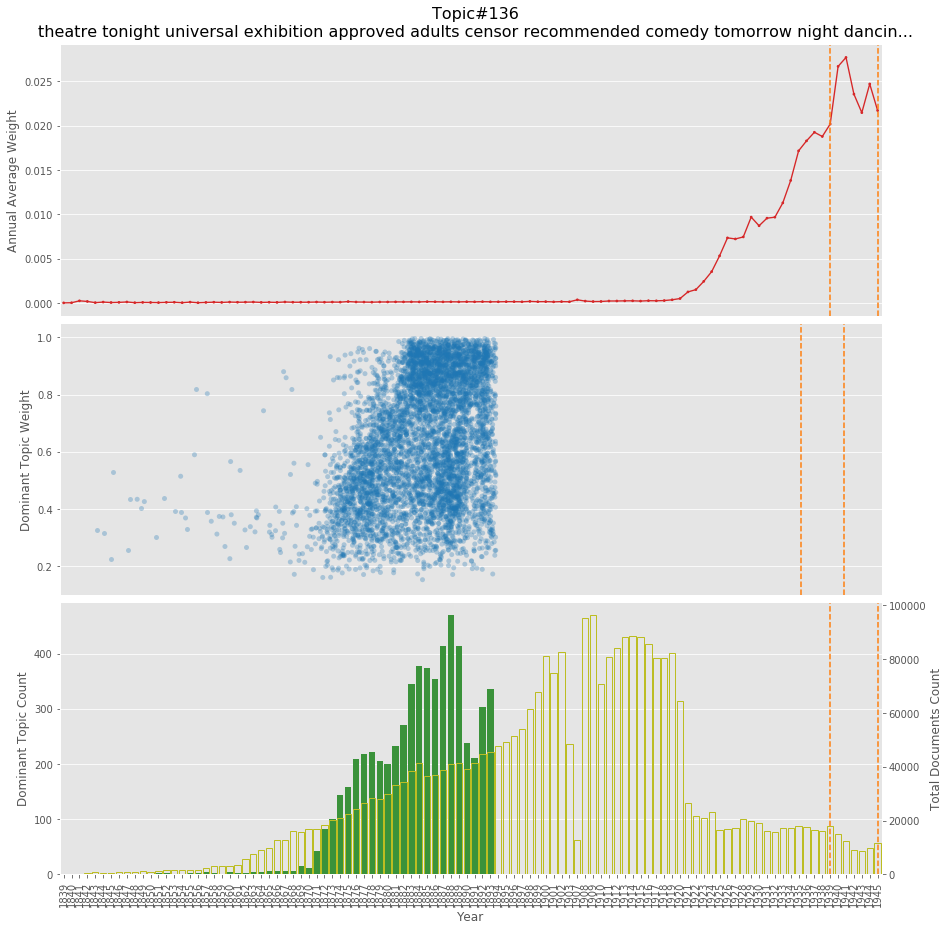

In [18]:
plot_hot(topic_event, df_topics, df_domtopic, df_avgweight, x1=start, x2=end)

### 3.3 Several Interesting Topics

#### 3.3.1 War, Peace, Entertainment, Strike

**Here we compare several interesting topics after 1908.**

In [15]:
topic_list = [105, 69, 159, 198]

# topic of interest
df_topics_toi = filter_topics(df_topics, topic_list)
legend_labels = list(df_topics_toi.keywords.str.slice(0,70)+'...')
df_topics_toi.head()

topic   weight  \
69      69  0.00744   
105    105  0.00663   
159    159  0.01358   
198    198  0.00768   

                                                                                                                    keywords  
69   german enemy germans front french british london fighting troops attack captured received line artillery russian sta...  
105  theatre picture pictures story programme to-night drama film comedy love star shown great girl play life feature nig...  
159  german germany war france peace french berlin russia government allies received london paris italy germans britain b...  
198  strike union men miners labour work workers coal federation association conference labor dispute unions wages strike...

In [16]:
# generate dataframe to plot
df_plt_avg = filter_topics(df_avgweight, topic_list)
df_plt_avg = df_plt_avg.pivot(index='year', columns='topic', values='weight')
# convert to time series
df_plt_avg.index = pd.to_datetime(df_plt_avg.index)

# constrain years
df_plt_avg = df_plt_avg[df_plt_avg.index >= '1908-01-01']

df_plt_avg.sort_index()
df_plt_avg.sample(5)

topic            69        105       159       198
year                                              
1908-01-01  0.000859  0.002345  0.007548  0.010928
1939-01-01  0.005972  0.009987  0.043187  0.003314
1917-01-01  0.074810  0.021919  0.062072  0.009791
1934-01-01  0.001179  0.009699  0.014625  0.003851
1941-01-01  0.031247  0.008280  0.042371  0.004226

**Plot:**

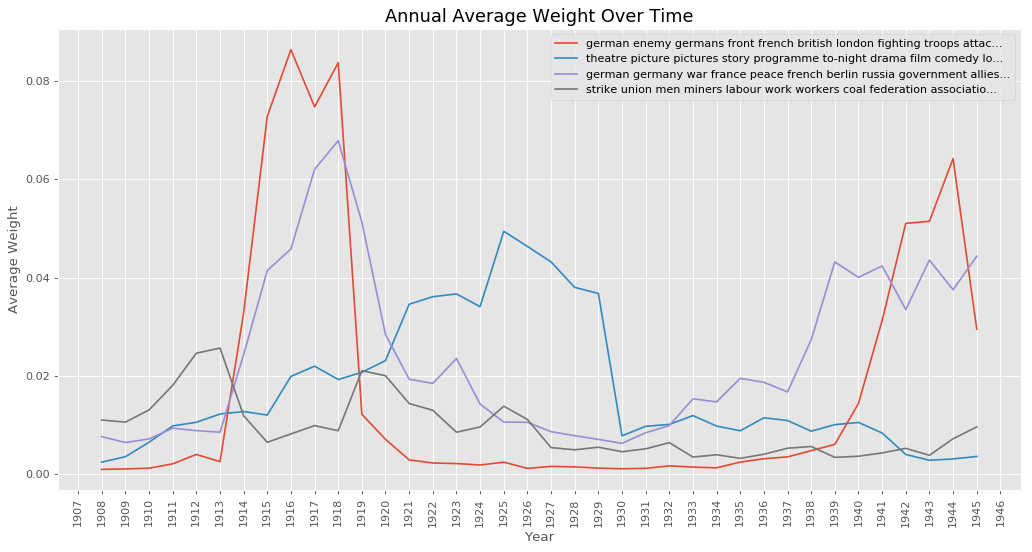

In [17]:
fig, ax = plt.subplots(figsize=(13, 7), dpi=dpi)

year = mdates.YearLocator(month=1)
year_format = mdates.DateFormatter('%Y')
ax.xaxis.set_major_locator(year)
ax.xaxis.set_major_formatter(year_format)

for i, c in enumerate(df_plt_avg.columns):
    plt.plot_date(df_plt_avg.index, df_plt_avg[df_plt_avg.columns[i]], '-')
    
plt.xlabel('Year')
plt.ylabel('Average Weight')
plt.xticks(rotation='90')
plt.title("Annual Average Weight Over Time", fontdict=dict(size=16))
ax.legend(labels=legend_labels)
plt.tight_layout()
plt.show()

**Seems war, peace, entertainment and strike have kinds of connection, war and peace have the save trend, while strike and entertainment have the different trand with war and peace during war, a good point to continue study.**

---

In [18]:
gc.collect()

47233